In [1]:
import numpy as np
import scipy
import scipy.io
import scipy.misc
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
import datetime
import imageio

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from six.moves import urllib

#CAUTION - 
#INVOLVES MANY VARIABLES WITH SAME NAME BUT DIFFERENT CONTEXT

C:\Users\Aditya agrawal\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Aditya agrawal\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Aditya agrawal\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Aditya agrawal\anaconda3\lib\site-packages\tensorflow\python\framework

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#uncomment below for sanity check 

#vgg_layers = scipy.io.loadmat('imagenet-vgg-verydeep-19.mat')['layers']
#W = vgg_layers[0][32][0][0][2][0][0]
#b = vgg_layers[0][32][0][0][2][0][1]
#layer_name = vgg_layers[0][32][0][0][0][0]

#b.reshape(b.size)
#print(W)
#print(b)
#print(layer_name)

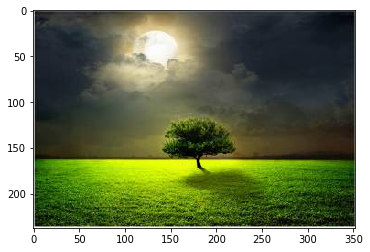

In [13]:
#ADJUSTING PARAMETERS,HYPER PARAMETERS AND CONSTANTS

#save to a directory with today's date and run label
output_dir_prefix = datetime.date.today().strftime('%m-%d-%Y') + "hong_k"

content_path = 'images/landscape.jpeg'    
style_path = 'images/night.jpg'
target_width = 500
target_height = 400

# CNN layers info
content_weight = 5   # content weights for total content loss
style_weight = 100        # style weights for total style loss 
w_c = np.array([1],dtype=np.float32)  # content weights for each layer
w_s = np.array([0.5, 1.0, 1.5, 3.0, 4.0],dtype=np.float32)  # style weights for each layer

#as given in paper
layer_list_content = ["conv4_2"]
layer_list_style = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]

#Optimization settings

epoches = 1000
#Learning rate depends on optimizer choice
lr = 10.0
noise_ratio = 0.6  # initial noise ratio
 
image = Image.open(content_path)
plt.imshow(image)
#image2 = Image.open(style_path)
#plt.imshow(image2)

In [14]:
#SETTING UP THE VARIABLES

def get_resized_image( img_path, save_path , width, height):
    
        
    image = Image.open(img_path)
    # PIL is column major so you have to swap the places of width and height
    image = ImageOps.fit(image, (width, height), Image.ANTIALIAS)
    imageio.imwrite(save_path, image)
    return image

    
def initialize_synthetic_image(noise_ratio, content_image ):
    
    '''Random uniform initialization mixed with content
        
    Returns:
        dtype= (1,H,W,C) np.float32 array. Note the dimension padding.
            
    '''
    noise_image = np.random.uniform(low=0,high= 256 , size = ( 400, 500 , 3)).astype(np.float32)
    #image_noise  =  preprocess(noise_image) * noise_ratio + content_image * (1 - noise_ratio)
    return noise_image

In [15]:
#IMAGE PREPROCESSING

def preprocess(input_img):
    
    value = np.asarray(input_img , dtype = np.float32)  #convert image into an array of (height , width , color channel)
    value = value[:, :, :3]
    value1 = np.expand_dims(value , axis = 0) 
    np.shape(value1)
    value2 = value1 - mean_pixels     #subtract the mean value
    return value2

def deprocess(image_deprocess):
    val = image_deprocess + mean_pixels
    val1 = val[0]
    np.shape(val1)
    return val1

In [16]:
# FOR SAVING THE IMAGES AND CREATE THE DIRECTORY
def make_dir(path):
    
    '''create the dir to save data'''
    if os.path.isdir(path):
        
        print('dir '+path+' exists, no need to create it.')
        pass
    else:
        
        print('dir '+path+' did not exist, now created')
        os.mkdir(path)
        
def save( path, image_unnormalized_nparray):
    
    
    '''add back VGG-19 pixel avgs to a processed image represented by a 
    (H,W,C) np.float32 array and save it to path'''
    
    image = deprocess(image_unnormalized_nparray)
    image = np.clip(image, 0, 255).astype('uint8')
    imageio.imwrite(path, image)

In [17]:
#CREATE THE DIRECTORY
make_dir(output_dir_prefix)

path1 = output_dir_prefix + "/reshaped_content.jpg"
path2 = output_dir_prefix+ "/reshaped_style.jpg"

# save source images before training occurs
# get back the processed image to feed into network
content_img = get_resized_image(content_path,path1 ,  target_width, target_height )
style_img = get_resized_image(style_path,path2 , target_width, target_height)



dir 07-19-2020hong_k exists, no need to create it.


In [18]:
#extracting weights and bias from pre-loaded vgg-19 model
#file is matlab file with structures and arrays

VGG_FILENAME = "imagenet-vgg-verydeep-19.mat"
#EXPECTED_BYTES = 534904783
#mean of VGG model to subtract from images before feeding

mean_pixels = np.array([123.68, 116.779, 103.939] , dtype=np.float32).reshape((1, 1, 1, 3))

def _weights( layer_id , expected_layer_name):
    vgg_layers = scipy.io.loadmat(VGG_FILENAME)["layers"] #contains all info as structures and arrays about layers
    W = vgg_layers[0][layer_id][0][0][2][0][0] 
    b = vgg_layers[0][layer_id][0][0][2][0][1]
    layer_name = vgg_layers[0][layer_id][0][0][0][0]

    layer_name = vgg_layers[0][layer_id][0][0][0][0]
    assert layer_name == expected_layer_name, print("Layer name error!")
    return W, b.reshape(b.size)

def conv2d_relu( prev_layer, layer_id, layer_name):
    
    with tf.variable_scope(layer_name):
        
        W, b = _weights(layer_id, layer_name)
        W = tf.constant(W, name="weights")
        b = np.reshape( b , b.size)
        b = tf.constant(b, name="bias")
        conv2d = tf.nn.conv2d(input=prev_layer,
                                  filter=W,
                                  strides=[1, 1, 1, 1],
                                  padding="SAME")
        out = tf.nn.relu(conv2d + b)
    return out


def avgpool( prev_layer, layer_name):
    
    with tf.variable_scope(layer_name):
        out = tf.nn.avg_pool(value=prev_layer,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    return out

#building the modified network
    
class VGG_build( object ):
    
    def __init__(self, input_img):
        self.activations = {}
        self.input_img = input_img
       
        self.activations['conv1_1']  = conv2d_relu(input_img, 0, "conv1_1")
        self.activations['conv1_2']  = conv2d_relu( self.activations['conv1_1'], 2, "conv1_2")
        self.activations['avgpool1'] = avgpool( self.activations['conv1_2'] , "avgpool1")
        self.activations['conv2_1'] =  conv2d_relu(self.activations['avgpool1'] , 5, "conv2_1")
        self.activations['conv2_2'] =  conv2d_relu(self.activations['conv2_1'] , 7, "conv2_2")
        self.activations['avgpool2'] = avgpool(self.activations['conv2_2'] , "avgpool2")
        self.activations['conv3_1'] =  conv2d_relu(self.activations['avgpool2'] , 10, "conv3_1")
        self.activations['conv3_2'] =  conv2d_relu(self.activations['conv3_1'] , 12, "conv3_2")
        self.activations['conv3_3'] =  conv2d_relu(self.activations['conv3_2'] , 14, "conv3_3")
        self.activations['conv3_4'] =  conv2d_relu(self.activations['conv3_3'] , 16, "conv3_4")
        self.activations['avgpool3'] = avgpool(self.activations['conv3_4'] , "avgpool3")
        self.activations['conv4_1'] =  conv2d_relu(self.activations['avgpool3'] , 19, "conv4_1")
        self.activations['conv4_2'] =  conv2d_relu(self.activations['conv4_1'] , 21, "conv4_2")
        self.activations['conv4_3'] =  conv2d_relu(self.activations['conv4_2'] , 23, "conv4_3")
        self.activations['conv4_4'] =  conv2d_relu(self.activations['conv4_3'] , 25, "conv4_4")
        self.activations['avgpool4'] =  avgpool(self.activations['conv4_4'] , "avgpool4")
        self.activations['conv5_1'] =  conv2d_relu(self.activations['avgpool4'] , 28, "conv5_1")
        self.activations['conv5_2'] =  conv2d_relu( self.activations['conv5_1'] , 30, "conv5_2")
        self.activations['conv5_3'] =  conv2d_relu(self.activations['conv5_2'] , 32, "conv5_3")
        self.activations['conv5_4'] =  conv2d_relu(self.activations['conv5_3'] , 34, "conv5_4")
        self.activations['avgpool5'] = avgpool(self.activations['conv5_4'], "avgpool5")
    
    
    def load(self, layer_name):
        result = self.activations[layer_name]
        return result


In [19]:
# compute the content_loss
#as directed in paper

def content_loss_func(content_activations, process_image , layer_list_content , w_c):
    
    
    
    #compute content loss for one layer 
    def content_loss(content_tensor, process_tensor ):
        
        '''Content loss for one layer
           Args:
           c_tensor: (B,H,W,C) tf.float32 tensor from style image
           p_tensor: (B,H,W,C) tf.float32 tensor from target image
        
           Returns:
           tf.float32 scalar, content loss in one layer
    
        '''
       
        c_tensor = content_tensor #extract the activation from the layer as tensor
        p_tensor = process_tensor
    
        N = int(c_tensor.shape[3])
        M = int(c_tensor.shape[1])* int(c_tensor.shape[2])
        
        result = (1 / 2) * tf.reduce_sum(tf.pow(c_tensor - p_tensor, 2))
        return result 
    
    i = 0
    total_content_loss = 0
    process_vgg = VGG_build(process_image)
    
    for layer in layer_list_content:
        content_tensor = content_activations[layer]
        process_tensor = process_vgg.load(layer)
        output = content_loss(content_tensor, process_tensor)
        total_content_loss +=  (w_c[i] *output)
        i = i+1
    return total_content_loss  
    


In [20]:
# compute the style loss
#as directed in paper

def style_loss_func(style_activations, process_image, layer_list_style , w_s ):
    
    def style_matrix(activation):
        channel_val = activation.get_shape().as_list()[-1]
        unwrap_out = tf.reshape(activation , ( -1 , channel_val))
        gram_matrix = tf.matmul( tf.transpose(unwrap_out) , unwrap_out)
        return gram_matrix
    
    def style_loss(style_tensor, process_tensor ):
        
    
        
        s_tensor = style_tensor
        p_tensor = process_tensor
       
        N = int(p_tensor.shape[3])
        M = int(p_tensor.shape[1])* int(p_tensor.shape[2])
        denominator = 4*(M*M)*(N*N)
    
        
        s_gram = style_matrix(s_tensor) #gram matrix of style image
        p_gram = style_matrix(p_tensor) #gram marix of target image
    
    
        diff = (s_gram-p_gram)
        result = (1 / denominator) * tf.reduce_sum(tf.pow(diff , 2))

        return result
    
    total_style_loss = 0
    i = 0
    process_vgg = VGG_build(process_image)
    
    for layer in layer_list_style:
        style_tensor = style_activations[layer]
        process_tensor = process_vgg.load(layer)
        output1 = style_loss(style_tensor, process_tensor )
        total_style_loss += (w_s[i] * output1)
        i = i+1
    
    return total_style_loss

In [21]:
#computing total cost

def sum_loss( content_weight, style_weight, content_activations , style_activations , process_image ):
    
    #Returns:
    #   total loss = content_weight*(sum(w_c*content_loss))+style_weight*(sum(w_s*style_loss))
    
    loss1 = content_loss_func(content_activations, process_image , layer_list_content , w_c)
    loss2 = style_loss_func(style_activations , process_image, layer_list_style , w_s )
    total = (content_weight*loss1) + (style_weight * loss2)
    
    return total, loss1, loss2

In [ ]:
#TRAINING

def train(max_epochs , lr):
    # Create a tensorflow session 
    sess = tf.Session()
    content_image = preprocess(content_img)
    style_image = preprocess(style_img)
    
    #now we have dictionary with layer name as keys and tensors as activations
    print("passing images through the network and return a dictionary")
    style_vgg = VGG_build(style_image)
    content_vgg = VGG_build(content_image)

    #["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
    style_activations = {}
    for val2 in layer_list_style:
        style_activations[val2] =  style_vgg.load(val2)
    
    content_activations = {}
    for val in layer_list_content:
        content_activations[val] = content_vgg.load(val)

    print("DONE!")
    
    #generate noise image
    generate_img = initialize_synthetic_image(noise_ratio,content_img)
    generate_image = preprocess(generate_img)  #preprocesssing
    
    #global step (passed to calculate learning rate decay
    global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name="global_step")
    
    #applyin learning rate decay for faster learning
    print("Using learning rate decay...")
    
    starter_learning_rate = lr
    end_learning_rate = lr/10
    decay_steps = 1000
    lr = tf.train.polynomial_decay(starter_learning_rate, global_step,
                                          decay_steps, end_learning_rate,
                                          power=1)
    
     # Create tensorflow variable to hold a stylized/generated image during the training 
    generated_image = tf.Variable(generate_image, dtype=tf.float32 , trainable = True)
    
    # Create our optimizer
    loss = sum_loss(content_weight , style_weight , content_activations , style_activations , generated_image)
    
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.9,beta2=0.999, epsilon=1e-08)
    
    train_step = opt.minimize( loss[0], global_step = global_step , var_list = [generated_image])
    
    
    
    sess.run(tf.global_variables_initializer())
    sess.run(generated_image.initializer)
    
    for i in range(max_epochs):
        
        sess.run(train_step)
        #unpack the tuple of loss
        total_loss, style_score, content_score = loss
        total_loss = total_loss.eval(session=sess)
        
        # print best loss
        print('best: iteration: ', i ,'loss: ', total_loss )
        
        best_img = generated_image.eval(session = sess)
        
        # Save image after every 100 iterations
        if (i+1)%100 == 0:
            step = i+1
            filename = output_dir_prefix+"/step_%d.png" % step
            best_image = deprocess(best_img)
            save(filename, best_img)
     
    sess.close()
    return best_img


best_image = train(epoches , lr)
filename = output_dir_prefix+"/final.jpg" 
save(filename, best_image)
    



passing images through the network and return a dictionary


In [ ]:
+